# ANALISIS DE DATOS DE IMÁGENES .fits
# Cáculo de probabilidades

La idea de este Notebook es ordenar los resultados del notebook general de análisis de imágenes .fits e incluir la teoría y los resultados en lo que respecta al cálculo de la probabilidad de que en un dado píxel aparezca una carga espuria (una o más).

Para eso lo que se va a hacer en este notebook es, a partir de analizar todas las imágenes y suponiendo que la variable aleatoria *número de cargas espurias por píxel* es Poissoniana, calcular el $\mu$ de la distribución.

\begin{equation}
    p(\mu|k) = \frac{\mu^{k}e^{-\mu}}{k!}
\end{equation}

In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

from analyfits.misc import fits_finder
from analyfits.manipufits import ManipulateFits
from analyfits import datafits

Busco los directorios de las imágenes

In [8]:
DIR = "/home/igna/Escritorio/Tesis2021/Archivos/T123K_B"
os.chdir(DIR)
fits_imgs_list = fits_finder(DIR)

Grafico las imágenes promediadas para el HDU 1 (que es el que anda bien del sensor). La idea de esta imagen es ver a grandes razgos las características generales del sensor. Pueden apreciarse hotpixels (píxeles que tienden a tener más seguido eventos espurios), particularmente en la columna 8, o algunas columnas que por algún motivo tienden a formar carga espuria. 

Además se puede observar el efecto de que los píxeles de las filas inferiores del sensor tienden a estar más iluminados. Esto es, en teoría, porque los píxeles de las filas inferiores son los últimos a los que se les mide la carga, con lo cual pueden estar más tiempo expuestos a fotones espurios.

100.00%

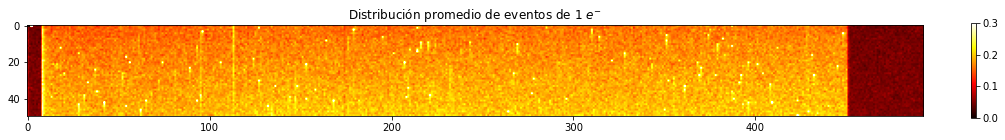

In [17]:
# ===========================================================================
image_prom = 0
N = len(fits_imgs_list)
for i, img in enumerate(fits_imgs_list):
    # src_path = DIR + elem
    fits_image = ManipulateFits()
    fits_image.set_ohdu(ohdu=0)
    image_prom += fits_image.single_fits2double_fits(img)[0]/N
    print("\r%.2f%%" % (100*i/(N-1)), end = "")

plt.figure(figsize=(17, 2))

plt.imshow(image_prom, cmap="hot", vmin=0, vmax=.3)
plt.colorbar(fraction=0.005)
plt.title("Distribución promedio de eventos de 1 $e^{-}$");

Otra forma de verlo es graficando el promedio de las 50 filas y viendo el perfil de carga. Se tienen que ver los escalones correspondientes al pre-scan y over-scan, a su vez de la columna 8 que tiene mucha más carga que el resto del sensor

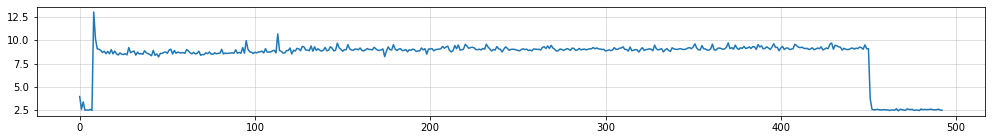

In [10]:
N_filas = image_prom[:, 0].size
suma = 0
for i in range(N_filas):
    suma += image_prom[i,:]

plt.figure(figsize=(17, 2))
plt.plot(suma)
plt.grid(alpha=.5)

En este útimo se ven 3 picos bien marcados, al principio y al rededor de la columna 100. Esto se ve en la imagen promediada de antes.

De la imagen promediada se puede obtener muy fácilmente la probabilidad "promedio" de que a un dado píxel le caiga un (y solo un) electrón. Esto es, calcular el valor medio de todos los elementos de la imagen. A su vez, la incerteza será la desviación estándar. 

Eso se implementa muy fácilmente

### Primer método: Promedio simple

In [11]:
# =============================================================================
active_reg_mean = np.mean(image_prom[:, 8:451])
active_reg_std = np.std(image_prom[:, 8:451])
print("La probabilidad de que un pixel tenga 1 electron es de %.4f +/- %.4f" % 
      (active_reg_mean, active_reg_std))

La probabilidad de que un pixel tenga 1 electron es de 0.1802 +/- 0.0213


Y el cálculo de $\mu$ a partir de esto y su error son

Usando la variable ```active_reg_mean``` que es la probabilidad de tener 1 evento de un electrón en la región activa del sensor y era $p = 0.18019833$ y asumiendo que la distribución de eventos es poissoniana (esta asunción en esta parte del notebook podría quedar fuera de lugar dado que la estoy haciendo mucho tiempo después), se puede tomar

\begin{equation}
    p(k = 1 | \mu) = \mu e^{-\mu} = 0.18019833
\end{equation}

y despejar $\mu$ iterativamente como sigue:

\begin{equation}
    \mu = \frac{0.18019833}{e^{-\mu}}
\end{equation}

tomando algún $\mu$ inicial

In [22]:
import time
mu = 1
sigma = active_reg_std
for i in range(40):
    mu = active_reg_mean/np.exp(-mu)
    sigma = np.sqrt(active_reg_std**2 + (np.exp(-2*mu)*sigma)**2)
    print(f"\r mu = {mu:.10f} +/- {sigma:.10f}", end="")
    time.sleep(0.05)

 mu = 0.2258607939 +/- 0.0275740841

Esta fue la implementación más sencilla para el cálculo de la probabilidad de que en un dado píxel haya carga que no corresponde con los generados por fotones de la fuente radioactiva. Tiene la desventaja de que justamente solo sirve para 1 electrón por píxel.

El segundo método hace uso de que la distribución de carga por pixel es poissoniana.

### Segundo método: Proporción de píxeles con 1 e 

El método consiste en el siguiente procedimiento

- Tomo una imagen y divido cada elemento de esa imágen por el número de píxeles sin eventos de 2 o más electrones.
- Toma la siguiente imagen, repito el paso anterior, y se la sumo a la imagen anterior.
- Repito hasta agotar las imágenes.
- Una vez que tengo una imagen suma de eventos de un electrón dividido por el número de píxeles sin eventos de 2 o más electrones, divido cada elemento de esa imagen sumada por el número total de imágenes que usé (para promediar sobre el número de imágenes).
- Ahora tengo una imagen que no significa nada, pero si sumo todos sus elementos, esa suma será la proporción "promedio", corregida por el número de píxeles ocupados por clústers, de tener un evento de 1 electrón por pixel del sensor.

### Escrito otra notación:

Tomo $Im_{i}$ como las matrices en $R^{n\times m}$ que representan a las imágenes con eventos de $1$ electrón, y $Mm_{i}$ como las matrices de $R^{n \times m}$ que representan a las imágenes con eventos de $2$ o más electrones. Donde $n = 50$ (filas) y $m = 493$ (columnas de la región activa). Defino una función $C$ tal que $C(Im_{i}|n)$ es el número de píxeles ocupados por eventos de $n$ electrones de la imagen $i$-ésima. De la misma forma, $C(Mm_{i}|\geq 2)$ es el número de píxeles ocupados por eventos de $2$ o más electrones (esto lo implemento con ```numpy``` de la siguiente manera: ```imagen[imagen == 1].size``` y ```imagen[image >= 2].size``` respectivamente).

El proceso que describo arriba puede resumirse con la expresión
\begin{equation}
    A = \frac{1}{N}\sum\limits_{i=1}^{N} \frac{Im_{i}}{L - C(Mm_{i}|\geq 2)}
\end{equation}

donde $L$ es el número total de píxeles de la región activa de una imagen ($22150$). El denominador es un escalar, o sea que estoy diviendo cada elemento de la matriz $Im_{i}$ por ese escalar y a su vez sumando sobre todas las imágenes. $N = 924$, el número total de imágenes. $A\ \in\ R^{n\times m}$ y no tiene interpretación *física*. 

Sin embargo, la suma de todos sus elementos termina siendo la proporción de píxeles ocupados por eventos de un electrón, descontando el sesgo de los píxeles ocupados por eventos de 2 o más electrones. Dicha proporción es la probabilidad de tener un electrón espurio por pixel (casos favorables / casos totales).

Entonces, la probabilidad sería

$$ P = \sum\limits_{i,j}^{n, m} A_{ij} $$

La implementación es

In [15]:
# ===========================================================================
# A será la matriz sin sentido físico de arriba
A = 0
# Cantidad total de imágenes
N = len(fits_imgs_list)

for i, elem in enumerate(fits_imgs_list):
    fits_image = ManipulateFits()
    minor, major = fits_image.single_fits2double_fits(elem)
    # redimensiono las imágenes para solo mirar la región activa
    minor = minor[:,8:451]
    major = major[:,8:451]
    # tomo el número total píxeles de la región activa
    total_size = major.size
    # tomo el número total píxeles ocupados por eventos de 2 o más electrones
    N_ev_2omas = major[major > 1].size
    # sumo las imágenes de 1 electrón ya divididas por el número de pixeles 
    # libres (sin eventos 2 o más e-)
    A += minor/(total_size - N_ev_2omas)
    # printeo el progreso
    print("\r%.2f%%" % (100*i/(N-1)), end = "")

# ahora divido el resultado anterior por el número de imágenes
A /= N
# finalmente, sumo todos los elementos (eso es el promedio)
probabilidad = np.sum(A)
print("\nLa probabilidad global resulta %.5f%%" % (probabilidad*100))

100.00%
La probabilidad global resulta 18.78325%


**OBS:** Esta probabilidad $P = 0.1878325$ es la probabilidad de que en un pixel haya solamente un electrón.

Notar que estoy dividiendo el número total de eventos de 1e, sobre el número total de píxeles del sensor (región activa) menos la cantidad de píxeles ocupados por 2 o más electrones. En definitiva es dividir por el número de píxeles del sensor con 0 y con 1 electrones.

Esta implementación tiene algunos problemas:
- Es difícil calcular la incerteza del valor.
- Es difícil ver el sesgo que añade dividir por N todos los píxeles, siendo que algunos píxeles en realidad no tiene el "aporte" de algunas imágenes, dado que estoy descontando eventos de 2 o más electrones. Es decir: Suponiendo que tengo 3 imágenes completas 1,2, y 3 y que el pixel $i$, en la imagen 1, tengo 1 electrón, en la imagen 2 tengo 0 electrones y en la imagen 3 tengo 50 electrones. El pixel $i$-ésimo de la tercera imagen en esta implementación, vale 0 y no aporta. Mientras que el píxel $i$-ésimo de la imagen 1 y 2 sí aportan. De forma que debería dividir por $N=2$ y no por $N=3$. En esta implementación estoy sesgando la medición al dividir siempre por $N$ fijo.

La idea detrás de este proceder es que se calcula la siguiente proporción:

\begin{equation}
    \frac{p(\mu|k=1)}{p(\mu|k=1) + p(\mu|k=0)} = \frac{\mu}{\mu + 1} = R \approx 0.1878
\end{equation}

de donde se puede despejar $\mu$

\begin{equation}
    \mu = \frac{R}{1-R} \approx 0.2313
\end{equation}

Es el valor de la media de la distribución Poissoniana según la cual se pueden poblar los píxeles de carga. Sigue teniendo el inconveniente de que no es fácil calcular la incerteza.

### Tercer método: Proporción de píxeles de 1 e- vs vacíos

Esta es una implementación muy sencilla y se basa en la misma teoría que antes. Pero en vez de mirar la proporción de píxeles con carga de 1 electrón sobre los píxeles con carga de 0 y 1 electrón, miro la proporción de píxeles con 1 sobre la proporción de píxeles con 0. Esto, en la teoría será

\begin{equation}
    \frac{p(\mu|k=1)}{p(\mu|k=0)} = \mu
\end{equation}

O sea que este método tiene la cualidad de devolver directamente el $\mu$ de la distribución. Además es fácil calcular el error por propagación

Entonces, sea $N$ el número total de píxeles ocupados por 1 electrón y sea $M$ el número total de píxeles ocupados por 0 electrones (ambas son variables aleatorias con distribución de Poisson (por qué esto?: Esbozo de respuesta - La variable aleatoria "número de píxeles con un solo electrón" es en rigor una variable aleatoria con distribución binomial, ya que hay una dada probabilidad $p$ de que un dado píxel tenga un electrón y eso se puede pensar como un experimento de Bernoulli de éxito/fracaso, donde el éxito es tener un electrón y el fracaso es tener 0. Para varios píxeles, son varios experimentos de Bernoulli y eso es la definición de distribución Binomial. Para el límite de $n >> 1$ y $p$ chico, con $n$ el número de experimentos, la Binomial es una Poisson.), defino $X$ como

\begin{equation}
    X = \frac{N}{M}
\end{equation}

Como $N$ y $M$ son Poissonianas, su error relativo es de la pinta $\frac{\sigma}{\mu}$, donde $\sigma = \sqrt{\mu}$, con lo cual el error relativo es $\frac{1}{\sqrt{\mu}}$. De esta forma, para $N$ es $1/\sqrt{N}$ y para $M$, $1/\sqrt{M}$. Para conocer la incerteza de $X$ hay que propagar las incertezas. La incerteza de $X$ la calculo con la siguiente expresión

\begin{equation}
    \left(\frac{\sigma(X)}{X}\right)^{2}
    = \left(\frac{\sigma(N)}{N}\right)^{2}
    + \left(\frac{\sigma(M)}{M}\right)^{2}
    \Longrightarrow
    \sigma(X) =
    X
    \left[
        \left(
            \frac{\sigma(N)}{N}
        \right)^{2}
        +
        \left(
            \frac{\sigma(M)}{M}
        \right)^{2}
    \right]^{1/2}
    = X
    \left[
        \frac{1}{N} + \frac{1}{M}
    \right]^{1/2}
\end{equation}

La implementación es trivial

In [16]:
# ===========================================================================
# Cantidad total de imágenes
N = len(fits_imgs_list)

# Guardo unas variables para ir acumulando la cantidad de píxeles con 0 y 1 e
ceros = 0
unos = 0

for i, img in enumerate(fits_imgs_list):
    # Uso las imágenes completas, solo en( su región activa
    image = ManipulateFits().ADU2e(img)[:, 8:451]
    # Guardo la cantidad de ceros de cada imagen y los voy sumando
    ceros += image[image==0].size
    # Idem para los unos 
    unos += image[image==1].size
    
    # Progreso:
    print("\r%.2f%%" % (100*i/(N-1)), end = "")

# Calculo la probabilidad de que en un pixel caiga un electrón espurio
probabilidad = unos/ceros

# Calculo el error relativo
error = np.sqrt((1/np.sqrt(unos))**2 + (1/np.sqrt(ceros))**2)*(unos/ceros)

# Imprimo resultado
print("\nLa probabilidad resulta %.4f +/- %.4f" % (probabilidad, error))

100.00%
La probabilidad resulta 0.2311 +/- 0.0001


## RESUMEN:

En este notebook se analizaron tanto analítica como visualmente las imágenes y se presentan los resultados más preponderantes de todos los análisis realizados en el notebook ```Analisis_de_Imagenes.ipynb```

#### Análisis de imágenes:
Se observan los hot-píxels en la imagen promediada. No se sabe bien que son, pero están. Píxeles más propensos que otros a acumular carga oscura. También (si se quiere) se puede ver los demás HDU.

#### Cálculo del $\mu$
Se calculó, primero una probabilidad promedio (de la región activa) de que en un dado píxel haya un evento de 1 electrón. Segundo, el valor del $\mu$ de la distribución de la variable aleatoria *cantidad de carga espuria por pixel*.

La probabilidad anterior fue de $0.1764 \pm 0.0210$. Sin embargo, esa era la probabilidad de tener 1 solo electrón por píxel. Notar que $p(\mu = 0.2245 | k = 1) \approx 0.1798$.

El valor del $\mu$ fue $\mu = 0.2245 \pm 0.0001$